In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
class node(object):
    
    def __init__(self,state):
        self.state=state
        self.inbound={}
        self.outbound={}
        self.cost=0
        
    def __str__(self):
        string="State: "+str(self.state)
        return string

In [3]:
n=6
U=10

np.random.seed(78440)
    
cvals=np.random.randint(1,U,n)
wvals=np.random.randint(1,U,n)
W=sum(wvals)/2
d=[0,1]

In [4]:
n1=50
U1=50
    
cvals1=np.random.randint(1,U1,n1)
wvals1=np.random.randint(1,U1,n1)
W1=sum(wvals1)/2

def read_instance(address = 'instance.csv'):
    data = pd.read_csv(address)
    c = data['c'].values
    w = data['w'].values
    W = data['W'].values[0]
    return c,w,W

In [5]:
nex=4

cvalsex=[7,8,6,14]
wvalsex=[3,3,4,6]
Wex=6

In [6]:
wvalstest = [27, 54, 18, 16, 44, 49, 82, 47, 70, 82, 91, 96, 33, 81, 48, 41, 48, 28, 91, 18, 80, 55, 5, 78, 74, 81, 11, 98, 26, 34, 47, 36, 66, 72, 55, 100, 42, 64, 9, 4, 67, 80, 15, 90, 32, 70, 57, 91, 48, 29, 78, 17, 9, 24, 2, 57, 92, 9, 42, 75, 58, 15, 78, 25, 12, 76, 14, 22, 8, 23, 79, 43, 50, 51, 70, 76, 89, 77, 77, 51, 50, 2, 67, 33, 38, 90, 31, 85, 15, 36, 38, 9, 5, 82, 84, 32, 52, 6, 36, 79, 60, 1, 47, 86, 48, 59, 85, 3, 65, 73, 31, 79, 48, 59, 76, 7, 16, 50, 85, 27, 89, 61, 17, 7, 29, 36, 60, 72, 53, 23, 6, 74, 35, 90, 37, 59, 96, 65, 3, 8, 97, 1, 72, 18, 48, 41, 68, 15, 26, 47, 27, 41, 20, 58, 92, 55, 47, 60, 26, 67, 8, 64, 6, 98, 92, 30, 42, 69, 61, 98, 2, 69, 62, 30, 4, 43, 44, 50, 22, 41, 96, 28, 100, 53, 24, 98, 49, 50, 13, 77, 77, 67, 70, 84, 17, 42, 48, 49, 8, 31, 36, 14, 23, 64, 22, 50, 27, 45, 37, 30, 64, 50, 38, 68, 54, 45, 30, 73, 23, 10, 98, 63, 56, 75, 61, 31, 3, 55, 35, 23, 57, 97, 29, 74, 40, 41, 78, 73, 71, 46, 97, 65, 92, 40, 36, 17, 47, 55, 12, 24, 84, 93, 50, 1, 95, 77, 2, 23, 71, 88, 34, 63, 94, 28, 32, 69, 66, 27, 1, 37, 33, 68, 41, 79, 44, 58, 12, 15, 73, 24, 8, 59, 5, 66, 18, 36, 76, 77, 44, 12, 8, 68, 45, 74, 26, 45, 90, 26, 49, 62, 82, 14, 26, 47, 14, 11, 64, 11, 19, 23, 65, 93, 10, 4, 87, 89, 99, 43, 93, 83, 100, 37, 99, 86, 80, 35, 72, 84, 21, 53, 27, 97, 22, 9, 25, 93, 40, 68, 71, 99, 75, 38, 95, 57, 55, 33, 81, 65, 80, 90, 24, 5, 83, 10, 81, 97, 82, 49, 71, 63, 88, 50, 92, 28, 55, 34, 54, 100, 5, 74, 93, 22, 43, 52, 84, 47, 84, 48, 30, 13, 89, 89, 23, 97, 7, 89, 40, 35, 60, 87, 20, 24, 13, 74, 11, 68, 98, 47, 46, 100]



cvalstest = [14, 26, 80, 51, 82, 9, 98, 36, 10, 100, 74, 4, 10, 82, 74, 56, 67, 33, 24, 19, 95, 95, 71, 63, 95, 52, 49, 4, 36, 17, 71, 29, 66, 13, 32, 17, 90, 80, 85, 55, 28, 26, 11, 48, 65, 77, 63, 52, 90, 68, 16, 79, 70, 15, 59, 55, 37, 61, 65, 87, 61, 88, 35, 93, 29, 14, 77, 19, 83, 25, 100, 19, 68, 67, 86, 9, 22, 29, 63, 60, 21, 52, 70, 89, 38, 74, 22, 17, 84, 71, 72, 8, 5, 38, 16, 17, 6, 13, 51, 99, 96, 75, 40, 12, 80, 50, 99, 84, 63, 1, 40, 86, 54, 97, 9, 23, 60, 35, 59, 47, 99, 89, 87, 59, 29, 17, 66, 31, 70, 22, 93, 55, 83, 39, 80, 51, 15, 11, 27, 49, 2, 95, 63, 2, 39, 40, 99, 73, 51, 21, 1, 22, 56, 15, 97, 12, 63, 96, 26, 28, 46, 62, 18, 89, 83, 68, 54, 55, 39, 23, 64, 91, 62, 42, 45, 70, 73, 80, 24, 91, 78, 35, 23, 34, 2, 91, 65, 70, 96, 46, 50, 60, 18, 16, 46, 57, 82, 22, 90, 47, 12, 21, 79, 10, 22, 20, 56, 5, 4, 24, 58, 32, 81, 40, 3, 74, 59, 33, 98, 50, 61, 92, 15, 58, 76, 36, 45, 58, 59, 7, 12, 100, 58, 85, 81, 32, 70, 74, 87, 99, 85, 66, 9, 82, 96, 35, 86, 96, 98, 52, 53, 42, 3, 43, 54, 88, 8, 44, 58, 31, 83, 79, 89, 22, 1, 37, 86, 36, 40, 8, 14, 22, 56, 17, 60, 27, 73, 85, 33, 62, 64, 84, 3, 10, 54, 41, 11, 62, 62, 22, 8, 45, 89, 57, 84, 94, 58, 51, 3, 7, 1, 75, 67, 87, 90, 53, 87, 60, 65, 61, 32, 1, 85, 8, 56, 54, 91, 67, 16, 80, 2, 87, 78, 92, 28, 5, 14, 23, 29, 39, 40, 54, 9, 75, 87, 57, 11, 3, 90, 45, 65, 87, 13, 81, 49, 7, 78, 64, 13, 47, 17, 38, 67, 82, 23, 88, 95, 73, 49, 95, 52, 15, 77, 1, 60, 29, 51, 38, 59, 14, 95, 27, 97, 11, 85, 33, 1, 57, 64, 36, 42, 57, 71, 33, 61, 55, 23, 50, 72, 64, 69, 100, 51, 46, 13, 79, 9, 58, 44, 86]

Wtest = 10114


ntest=len(wvalstest)


In [7]:
def Algorithm_1(n,cvals,wvals,W):
    
    all_layers={}
    all_layers[0]={}
    all_layers[0][0]=node(0)
    
    #Iterate through each layer
    for x in range(1,n):
        #Create next layer
        currLayer=all_layers[x-1]
        all_layers[x]={}
        nextLayer=all_layers[x]
        #Initialize layer variables
        w_current=wvals[x-1]
        c_current=cvals[x-1]
        
        for old_state, nodeInstance in currLayer.items():
            new_node=node(old_state)
            nextLayer[old_state]=new_node
            nodeInstance.outbound[new_node]=0
            new_node.inbound[nodeInstance]=0
        
        #Iterate through each node and action decision
        for nodeInstance in currLayer.values():
            newstate=nodeInstance.state+w_current
            #Feasability check
            #Check if the new state already exists in the layer
            if newstate<=W:
                if newstate in nextLayer:
                    #Add arc into arclist
                    #Add arc into node inbound and outbound
                    nodeInstance.outbound[nextLayer[newstate]]=c_current
                    nextLayer[newstate].inbound[nodeInstance]=c_current
                else:
                    #Create new node, add arc to arclist
                    new_node=node(newstate)
                    nextLayer[newstate]=new_node
                    #Add arc to node inbound and outbound
                    nodeInstance.outbound[new_node]=c_current
                    new_node.inbound[nodeInstance]=c_current
                        
    #POSSIBLE TECHNIQUE
    #COPY ARC NODES FROM UPPER LAYER INTO LOWER LAYER TO REDUCE MAKING MORE AND MORE NODES
    #MAY REQUIRE DEEP COPYING TO REDUCE LINKAGE
        
    #Changed from W because Rachel said so
    terminal_node=node(-10)
    all_layers[n]={}
    all_layers[n][-10]=terminal_node
    
    w_final=wvals[n-1]
    c_final=cvals[n-1]
    
    for nodeInstance in all_layers[n-1].values():
        
        nodeInstance.outbound[terminal_node]=0
        terminal_node.inbound[nodeInstance]=0
    
    for nodeInstance in all_layers[n-1].values():
        
        newstate=nodeInstance.state+w_final
        
        if newstate<=W:
            nodeInstance.outbound[terminal_node]=c_final
            terminal_node.inbound[nodeInstance]=c_final
                
    #final_node=node(0)            
    #terminal_node.outbound[final_node]=0
                
    return all_layers

In [8]:
def Algorithm_2(reduced_layers,n):
     #Final reduction algorithm here we go
    #Starting from the second last layer moving up
    
    #CHANGE TO ITERATING OVER ITEMS DIRECTLY NOT INDEXING 
    #Can this be done in reverse order though
    
    for x in range(n-1,0,-1):
        #all_tails_found=False
        to_remove={}
        tail_list={}
        for nodeInstance in reduced_layers[x].values():
            #Add ending combination if not already in the tail list
            current_tuple=tuple(nodeInstance.outbound.items())
            
            if current_tuple not in tail_list:
                tail_list[current_tuple]=nodeInstance
            
            #If ending combination exists
            else:
                to_remove[nodeInstance.state]=nodeInstance
                #Redirect arcs
                for comingFrom, arcCost in nodeInstance.inbound.items():
                    tail_list[current_tuple].inbound[comingFrom]=arcCost
                    comingFrom.outbound[tail_list[current_tuple]]=arcCost
                    #Remove arcs from comingFrom node
                    if nodeInstance in comingFrom.outbound:
                        del(comingFrom.outbound[nodeInstance])
                        
        #Remove all duplicate nodes            
        for remove_node in to_remove.values():
            del(reduced_layers[x][remove_node.state])
            remove_node=None
        
    return reduced_layers

In [9]:
def Longest_Path(reduced_layers,cvals):
    #Initiate final score and trail list
    final_score=0
    trail=[0]*(len(reduced_layers)-1)
    
    #Iterate through every node and incoming arc, update highest cost found
    for layer in reduced_layers.values():
        for nodeInstance in layer.values():
            for comingFrom in nodeInstance.inbound:
                #Only update arcs where cost > 0
                if (comingFrom.cost+nodeInstance.inbound[comingFrom])>nodeInstance.cost:
                    nodeInstance.cost=comingFrom.cost+nodeInstance.inbound[comingFrom]
    
    #In the last layer of nodes find the node with the largest cost and set it as the final score
    for nodeInstance in reduced_layers[len(cvals)].values():
        final_score=nodeInstance.cost
        break
            
    traceback_score=final_score
    
    #Trace back from terminal to root
    for x in range(len(reduced_layers)-2,-1,-1):
        
        c_current=cvals[x]
        new_traceback=traceback_score-c_current
        
        for nodeInstance in reduced_layers[x].values():
            if (nodeInstance.cost==new_traceback):
                trail[x]=1
                traceback_score=new_traceback
                break
    
    return final_score, trail

In [10]:
def Complexity_Testing(n):
    
    y=[]
    Algo_1=[]
    Sol_1=[]
    Algo_2=[]
    Sol_2=[]
    Full_Solve=[]
    Reduced_Solve=[]
    
    for n_test in range(5,n+1):
        
        U_test=n_test
        c_test=np.random.randint(1,U_test,n_test)
        w_test=np.random.randint(1,U_test,n_test)
        W_test=sum(w_test)/2
        
        start1=time.time()
        all_layers=Algorithm_1(n_test,c_test,w_test,W_test)
        end1=time.time()
        [full_finalScore,full_trail]=Longest_Path(all_layers,c_test)
        end2=time.time()
        reduced_layers=Algorithm_2(all_layers,n_test)
        end3=time.time()
        [reduced_finalScore,reduced_trail]=Longest_Path(reduced_layers,c_test)
        end4=time.time()
        
        y.append(n_test)
        Algo_1.append(end1-start1)
        Sol_1.append(end2-end1)
        Algo_2.append(end3-end2)
        Sol_2.append(end4-end3)
        Full_Solve.append(end2-start1)
        Reduced_Solve.append((end4-end2)+(end1-start1))
    
    #plt.plot(y,Algo_1,label="Building")
    #plt.plot(y,Sol_1,label="Full solve")
    #plt.plot(y,Algo_2,label="Reduction")
    #plt.plot(y,Sol_2,label="Reduced solve")
    plt.plot(y,Full_Solve,label="Full Solve")
    plt.plot(y,Reduced_Solve,label="Reduced Solve")
    
    
    plt.legend()
    plt.show()
        
    return None

In [11]:
[cvals2,wvals2,W2]=read_instance()
n2=len(cvals2)

In [12]:
testset=[n2,cvals2,wvals2,W2]

start1=time.time()
all_layers=Algorithm_1(testset[0],testset[1],testset[2],testset[3])
end1=time.time()
[full_finalScore,full_trail]=Longest_Path(all_layers,testset[1])
end2=time.time()

reduced_layers=Algorithm_2(all_layers,testset[0])
end3=time.time()
[reduced_finalScore,reduced_trail]=Longest_Path(reduced_layers,testset[1])
end4=time.time()

if(full_finalScore==np.dot(full_trail,testset[1])):
    full_check="Passed!"
else:
    full_check="Failed"

if(reduced_finalScore==np.dot(reduced_trail,testset[1])):
    reduced_check="Passed!"
else:
    reduced_check="Failed"

In [13]:
#Just printing stuff, no biggie
    
print("Full BDD Build Time: {}ms".format(1000*(end1-start1)))
print("Full BDD Score Runtime: {}ms".format(1000*(end2-end1)))
print("Full BDD Optimal Solution: {}".format(full_finalScore))
print("Sanity Check: {}\n".format(full_check))
#print("Full BDD Trail: {}\n".format(full_trail))


print("BDD Reduction Time: {}ms".format(1000*(end3-end2)))
print("Reduced BDD Solution: {}ms".format(1000*(end4-end3)))
print("Reduced BDD Optimal Solution: {}".format(reduced_finalScore))
print("Sanity Check: {}\n".format(reduced_check))
#print("Reduced BDD Trail: {}\n".format(reduced_trail))

print("Total Runtime: {}s".format(end4-start1))

Full BDD Build Time: 128.9231777191162ms
Full BDD Score Runtime: 72.95751571655273ms
Full BDD Optimal Solution: 719
Sanity Check: Passed!

BDD Reduction Time: 32.980918884277344ms
Reduced BDD Solution: 34.98029708862305ms
Reduced BDD Optimal Solution: 719
Sanity Check: Passed!

Total Runtime: 0.26984190940856934s


In [14]:
#Printing node and layer information
'''for key, layer in all_layers.items():
    print("Layer no: {}".format(key))
    print("Nodes in layer: {}".format(len(layer.values())))
    print("")
    for currWeight, nodeInstance in layer.items():
        print("Node: {}".format(currWeight))
        for goingTo, arcCost in nodeInstance.outbound.items():
            print("Arc cost: {}".format(arcCost))
    print("")'''

'for key, layer in all_layers.items():\n    print("Layer no: {}".format(key))\n    print("Nodes in layer: {}".format(len(layer.values())))\n    print("")\n    for currWeight, nodeInstance in layer.items():\n        print("Node: {}".format(currWeight))\n        for goingTo, arcCost in nodeInstance.outbound.items():\n            print("Arc cost: {}".format(arcCost))\n    print("")'

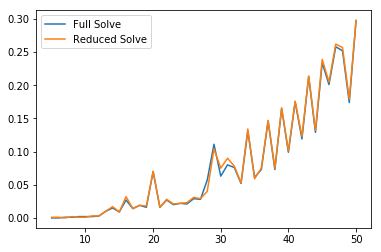

In [15]:
#Complexity testig
#Complexity_Testing(50)